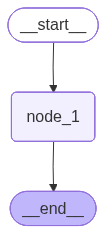

In [49]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 2}

builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 3}

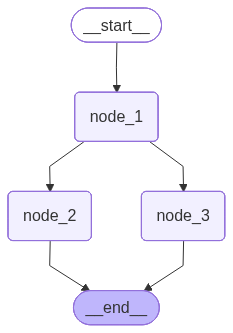

In [51]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 2}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 2}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 2}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


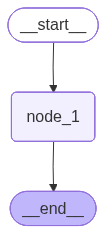

In [53]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 2]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 3]}

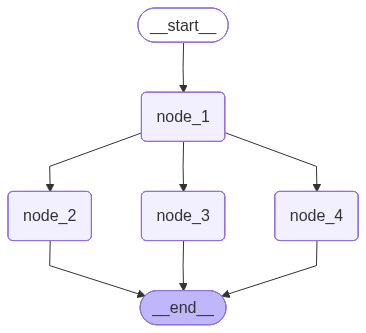

In [55]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 2]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 2]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 2]}

def node_4(state):
    print("---Node 4---")
    return {"foo": [state['foo'][-1] + 2]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_1", "node_4")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---
---Node 4---


{'foo': [1, 3, 5, 5, 5]}

In [57]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [58]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

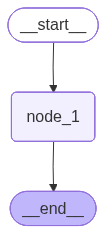

TypeError occurred: can only concatenate list (not "NoneType") to list


In [59]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [4]}

builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

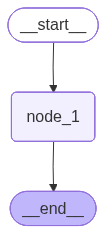

---Node 1---
{'foo': [4]}


In [60]:
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

In [61]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    added_key_3: str


class ExtendedMessagesState(MessagesState): 
    added_key_1: str
    added_key_2: str
    added_key_3: str

In [62]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking to know about Fifa World Cup 2026.", name="Rao")
                   ]

new_message = AIMessage(content="Sure, I can help with that. What specifically do you want to know?", name="Model")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='8d1f20f4-ea9a-4a27-8962-4761454d8e17'),
 HumanMessage(content="I'm looking to know about Fifa World Cup 2026.", additional_kwargs={}, response_metadata={}, name='Rao', id='f7d33ecb-0ed5-41ef-a956-8419bbfa3c0a'),
 AIMessage(content='Sure, I can help with that. What specifically do you want to know?', additional_kwargs={}, response_metadata={}, name='Model', id='c21b6afe-ae65-4cd4-9dec-f210afbc3848')]

In [63]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking to know about Fifa World Cup 2026.", name="Rao", id="2")
                   ]

new_message = HumanMessage(content="I want to know which teams qualified for the world cup.", name="Rao", id="2")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content='I want to know which teams qualified for the world cup.', additional_kwargs={}, response_metadata={}, name='Rao', id='2')]

In [64]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Rao", id="2"))
messages.append(AIMessage("So you said you wanted to know about Fifa World Cup 2026?", name="Bot", id="3"))
messages.append(HumanMessage("Yes. But what do you think are important information to know?", name="Rao", id="4"))

delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [65]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you wanted to know about Fifa World Cup 2026?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes. But what do you think are important information to know?', additional_kwargs={}, response_metadata={}, name='Rao', id='4')]